In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True
torch.cuda.set_device(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 Tesla T4


In [46]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_LABEL = {"MNIST": 10, "KMNIST": 10, "FLOWER": 102}
ACTIVATE_FN = {"RELU": 0, "ELU": 1, "LEAKYRELU": 2}

##LOAD DATA

In [5]:
# transform setting
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, 0.5)
])

transform_kmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, 0.5)
])

transform_flower = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, 0.5)
])

In [6]:
# MNIST dataloader 
trainset_mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform_mnist)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testset_mnist = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform_mnist)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# KMNIST dataloader 
trainset_kmnist = torchvision.datasets.KMNIST(root="./data", train=True, download=True, transform=transform_kmnist)
trainloader_kmnist = torch.utils.data.DataLoader(trainset_kmnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testset_kmnist = torchvision.datasets.KMNIST(root="./data", train=False, download=True, transform=transform_kmnist)
testloader_kmnist = torch.utils.data.DataLoader(testset_kmnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [8]:
# FLOWER102 dataloader
trainset_flower = torchvision.datasets.Flowers102(root="./data", split='test', download=True, transform=transform_flower)
trainloader_flower = torch.utils.data.DataLoader(trainset_flower, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testset_flower = torchvision.datasets.Flowers102(root="./data", split='train', download=True, transform=transform_flower)
testloader_flower = torch.utils.data.DataLoader(testset_flower, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting data/flowers-102/102flowers.tgz to data/flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

##MODEL

In [9]:
from torch.nn.modules import BatchNorm2d
class Net(nn.Module):
    def __init__(self, nf=1, nclass=10, model_type="MNIST", activate_fn=0):
        super(Net, self).__init__()
        self.model_type = model_type
        self.activate_fn = [nn.ReLU(inplace=True), nn.ELU(inplace=True), nn.LeakyReLU(inplace=True)]
        self.MNISTnet = nn.Sequential(
            nn.Conv2d(nf, 6, 5),
            self.activate_fn[activate_fn],
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            self.activate_fn[activate_fn],
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            self.activate_fn[activate_fn],
            nn.Linear(120, 84),
            self.activate_fn[activate_fn],
            nn.Linear(84, nclass),
            nn.Softmax(1)
        )

        self.KMNISTnet = nn.Sequential(
            nn.Conv2d(nf, 6, 5),
            self.activate_fn[activate_fn],
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            self.activate_fn[activate_fn],
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            self.activate_fn[activate_fn],
            nn.Linear(120, 84),
            self.activate_fn[activate_fn],
            nn.Linear(84, nclass),
            nn.Softmax(1)
        )

        self.FLOWERnet = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            self.activate_fn[activate_fn],
            nn.BatchNorm2d(6),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),
            self.activate_fn[activate_fn],
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 5),
            self.activate_fn[activate_fn],
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 16, 5),
            self.activate_fn[activate_fn],
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(16 * 12 * 12, 512),
            self.activate_fn[activate_fn],
            nn.Linear(512, 256),
            self.activate_fn[activate_fn],
            nn.Linear(256, nclass)
        )


    def forward(self, x):
        if self.model_type == "MNIST":
            # input shape = batch, 1, 28, 28
            out = self.MNISTnet(x)
        elif self.model_type == "KMNIST":
            # input shape = batch, 1, 28, 28
            out = self.KMNISTnet(x)
        elif self.model_type == "FLOWER":
            # input shape = batch, 3, 480, 480
            out = self.FLOWERnet(x)
            #out = self.MNISTnet(x)
        else:
            print("ERROR!")
        return out
        
net = Net(nf=3, nclass=102, model_type="FLOWER")
ins = torch.randn(20, 3, 256, 256)
outs = net(ins)
print(outs.shape)

torch.Size([20, 102])


##TRAIN & TEST FUNCTION

In [10]:
def train(net, dataloader, epochs=50, lr=0.001):
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

    losses = []
    start_time = time.time()
    try:
        for epoch in range(epochs):
            running_loss = 0.0
            total_sample = 0
            print(f"epoch: {epoch}")
            for data in tqdm(dataloader):
                inputs, labels = data[0].to(device), data[1].to(device)
                    
                optimizer.zero_grad()
                outs = net(inputs)
                loss = criterion(outs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                total_sample += inputs.size(0)
                #print(f"\r\tbatch{inputs.size(0)}, loss:{loss.item():.3f}", end='')
                
            epoch_loss = running_loss / total_sample
            losses.append(epoch_loss)
            print(f"\n epoch_loss: {epoch_loss:.3f}")

    except KeyboardInterrupt:
        print("Stop training")


    print(f"Finished Training for {time.time() - start_time:.2f} s")
    print("show loss")
    plt.plot(np.array(losses), 'r')
    return net

In [11]:
def test(net, dataloader, numlabel):
    class_correct = [0] * numlabel
    class_total = [0] * numlabel
    preds = np.zeros((1))
    truth = np.zeros((1))

    print("start testing...")
    net.eval()
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs, labels = data[0].to(device), data[1]
            outputs = net(inputs)

            _, predicted = torch.max(outputs, 1)
            c = (predicted.cpu() == labels).squeeze()
            preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
            truth = np.concatenate([truth, labels.numpy()], axis=0)

            for i in range(labels.shape[0]):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
    print()
    for i in range(numlabel):
        try:
            print("Accuracy of %5s : %2d %%" % (i, 100 * class_correct[i] / class_total[i]))
        except:
            print(" Accuracy of %5s :  total = 0" % (i))
    print("Accuracy of   ALL : %2d %%" % (100 * sum(class_correct) / sum(class_total)))

    arr = confusion_matrix(truth, preds)
    class_names = list(range(numlabel))
    df_cm = pd.DataFrame(arr, class_names, class_names)
    plt.figure(figsize =(9, 6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="BuGn")
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")

##TEST CASE : MNIST / RELU / 20 EPS 

epoch: 0


100%|██████████| 938/938 [00:11<00:00, 81.37it/s]



 epoch_loss: 2.302
epoch: 1


100%|██████████| 938/938 [00:11<00:00, 82.79it/s]



 epoch_loss: 2.300
epoch: 2


100%|██████████| 938/938 [00:11<00:00, 82.00it/s]



 epoch_loss: 2.297
epoch: 3


100%|██████████| 938/938 [00:11<00:00, 81.27it/s]



 epoch_loss: 2.255
epoch: 4


100%|██████████| 938/938 [00:11<00:00, 81.47it/s]



 epoch_loss: 1.981
epoch: 5


100%|██████████| 938/938 [00:11<00:00, 82.21it/s]



 epoch_loss: 1.709
epoch: 6


100%|██████████| 938/938 [00:11<00:00, 82.04it/s]



 epoch_loss: 1.597
epoch: 7


100%|██████████| 938/938 [00:11<00:00, 81.85it/s]



 epoch_loss: 1.568
epoch: 8


100%|██████████| 938/938 [00:11<00:00, 81.69it/s]



 epoch_loss: 1.550
epoch: 9


100%|██████████| 938/938 [00:11<00:00, 81.80it/s]



 epoch_loss: 1.538
epoch: 10


100%|██████████| 938/938 [00:11<00:00, 82.47it/s]



 epoch_loss: 1.529
epoch: 11


100%|██████████| 938/938 [00:11<00:00, 81.50it/s]



 epoch_loss: 1.522
epoch: 12


100%|██████████| 938/938 [00:11<00:00, 82.02it/s]



 epoch_loss: 1.517
epoch: 13


100%|██████████| 938/938 [00:11<00:00, 81.64it/s]



 epoch_loss: 1.512
epoch: 14


100%|██████████| 938/938 [00:13<00:00, 70.61it/s]



 epoch_loss: 1.509
epoch: 15


100%|██████████| 938/938 [00:11<00:00, 81.78it/s]



 epoch_loss: 1.506
epoch: 16


100%|██████████| 938/938 [00:11<00:00, 80.89it/s]



 epoch_loss: 1.504
epoch: 17


100%|██████████| 938/938 [00:11<00:00, 80.59it/s]



 epoch_loss: 1.502
epoch: 18


100%|██████████| 938/938 [00:11<00:00, 80.91it/s]



 epoch_loss: 1.500
epoch: 19


100%|██████████| 938/938 [00:11<00:00, 81.58it/s]



 epoch_loss: 1.499
Finished Training for 231.70 s
show loss


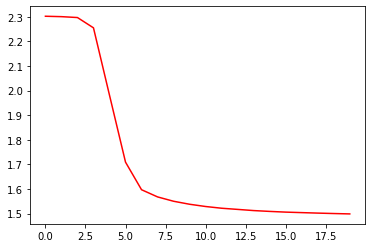

In [53]:
net = train(Net(nf=1, nclass=10, model_type="MNIST"), trainloader_mnist, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 157/157 [00:01<00:00, 85.84it/s]



Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 97 %
Accuracy of     4 : 98 %
Accuracy of     5 : 93 %
Accuracy of     6 : 97 %
Accuracy of     7 : 94 %
Accuracy of     8 : 94 %
Accuracy of     9 : 95 %
Accuracy of   ALL : 96 %


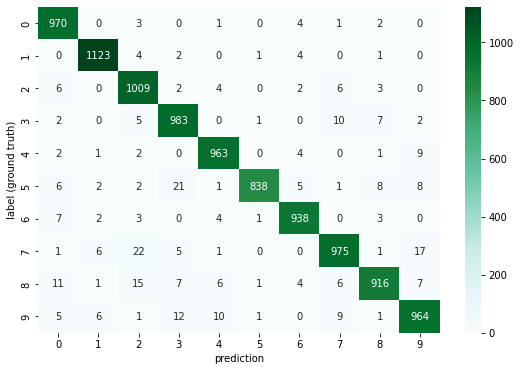

In [54]:
test(net, testloader_mnist, numlabel=NUM_LABEL["MNIST"])

##TEST CASE MNIST / ELU / 20 EPS

epoch: 0


100%|██████████| 938/938 [00:11<00:00, 81.86it/s]



 epoch_loss: 2.301
epoch: 1


100%|██████████| 938/938 [00:12<00:00, 75.56it/s]



 epoch_loss: 2.291
epoch: 2


100%|██████████| 938/938 [00:11<00:00, 80.46it/s]



 epoch_loss: 2.140
epoch: 3


100%|██████████| 938/938 [00:11<00:00, 79.60it/s]



 epoch_loss: 1.706
epoch: 4


100%|██████████| 938/938 [00:12<00:00, 76.77it/s]



 epoch_loss: 1.587
epoch: 5


100%|██████████| 938/938 [00:11<00:00, 79.70it/s]



 epoch_loss: 1.561
epoch: 6


100%|██████████| 938/938 [00:11<00:00, 78.35it/s]



 epoch_loss: 1.545
epoch: 7


100%|██████████| 938/938 [00:12<00:00, 78.04it/s]



 epoch_loss: 1.534
epoch: 8


100%|██████████| 938/938 [00:11<00:00, 79.08it/s]



 epoch_loss: 1.525
epoch: 9


100%|██████████| 938/938 [00:11<00:00, 79.69it/s]



 epoch_loss: 1.518
epoch: 10


100%|██████████| 938/938 [00:11<00:00, 79.16it/s]



 epoch_loss: 1.513
epoch: 11


100%|██████████| 938/938 [00:11<00:00, 79.27it/s]



 epoch_loss: 1.509
epoch: 12


100%|██████████| 938/938 [00:11<00:00, 80.45it/s]



 epoch_loss: 1.506
epoch: 13


100%|██████████| 938/938 [00:11<00:00, 78.55it/s]



 epoch_loss: 1.503
epoch: 14


100%|██████████| 938/938 [00:11<00:00, 78.33it/s]



 epoch_loss: 1.501
epoch: 15


100%|██████████| 938/938 [00:12<00:00, 74.09it/s]



 epoch_loss: 1.499
epoch: 16


100%|██████████| 938/938 [00:11<00:00, 79.26it/s]



 epoch_loss: 1.497
epoch: 17


100%|██████████| 938/938 [00:11<00:00, 79.05it/s]



 epoch_loss: 1.496
epoch: 18


100%|██████████| 938/938 [00:12<00:00, 74.50it/s]



 epoch_loss: 1.494
epoch: 19


100%|██████████| 938/938 [00:11<00:00, 78.20it/s]



 epoch_loss: 1.493
Finished Training for 239.35 s
show loss


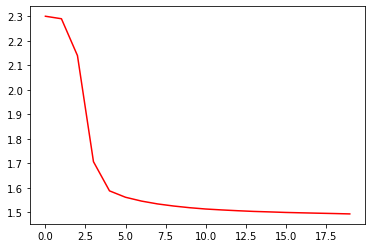

In [14]:
net = train(Net(nf=1, nclass=10, model_type="MNIST", activate_fn=ACTIVATE_FN["ELU"]), trainloader_mnist, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 157/157 [00:01<00:00, 81.67it/s]



Accuracy of     0 : 98 %
Accuracy of     1 : 98 %
Accuracy of     2 : 97 %
Accuracy of     3 : 98 %
Accuracy of     4 : 97 %
Accuracy of     5 : 96 %
Accuracy of     6 : 97 %
Accuracy of     7 : 97 %
Accuracy of     8 : 95 %
Accuracy of     9 : 95 %
Accuracy of   ALL : 97 %


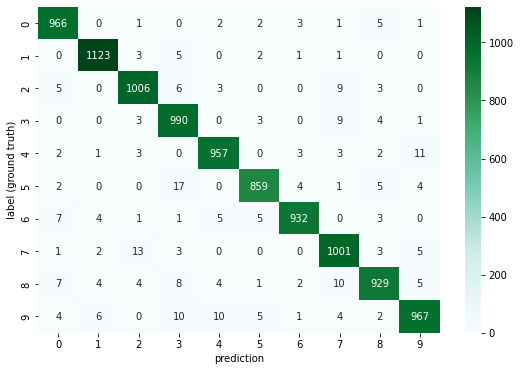

In [15]:
test(net, testloader_mnist, numlabel=NUM_LABEL["MNIST"])

##TEST CASE MNIST / LEAKYRELU / 20 EPS

epoch: 0


100%|██████████| 938/938 [00:11<00:00, 79.04it/s]



 epoch_loss: 2.302
epoch: 1


100%|██████████| 938/938 [00:12<00:00, 78.09it/s]



 epoch_loss: 2.302
epoch: 2


100%|██████████| 938/938 [00:11<00:00, 78.78it/s]



 epoch_loss: 2.301
epoch: 3


100%|██████████| 938/938 [00:12<00:00, 77.99it/s]



 epoch_loss: 2.299
epoch: 4


100%|██████████| 938/938 [00:12<00:00, 77.82it/s]



 epoch_loss: 2.293
epoch: 5


100%|██████████| 938/938 [00:12<00:00, 78.08it/s]



 epoch_loss: 2.194
epoch: 6


100%|██████████| 938/938 [00:11<00:00, 78.82it/s]



 epoch_loss: 1.813
epoch: 7


100%|██████████| 938/938 [00:11<00:00, 78.20it/s]



 epoch_loss: 1.620
epoch: 8


100%|██████████| 938/938 [00:12<00:00, 78.02it/s]



 epoch_loss: 1.568
epoch: 9


100%|██████████| 938/938 [00:11<00:00, 78.31it/s]



 epoch_loss: 1.547
epoch: 10


100%|██████████| 938/938 [00:11<00:00, 78.58it/s]



 epoch_loss: 1.534
epoch: 11


100%|██████████| 938/938 [00:12<00:00, 76.95it/s]



 epoch_loss: 1.525
epoch: 12


100%|██████████| 938/938 [00:12<00:00, 76.11it/s]



 epoch_loss: 1.517
epoch: 13


100%|██████████| 938/938 [00:11<00:00, 79.12it/s]



 epoch_loss: 1.512
epoch: 14


100%|██████████| 938/938 [00:12<00:00, 77.67it/s]



 epoch_loss: 1.508
epoch: 15


100%|██████████| 938/938 [00:12<00:00, 74.51it/s]



 epoch_loss: 1.505
epoch: 16


100%|██████████| 938/938 [00:11<00:00, 79.42it/s]



 epoch_loss: 1.502
epoch: 17


100%|██████████| 938/938 [00:11<00:00, 78.54it/s]



 epoch_loss: 1.500
epoch: 18


100%|██████████| 938/938 [00:11<00:00, 78.53it/s]



 epoch_loss: 1.499
epoch: 19


100%|██████████| 938/938 [00:11<00:00, 78.64it/s]



 epoch_loss: 1.497
Finished Training for 240.59 s
show loss


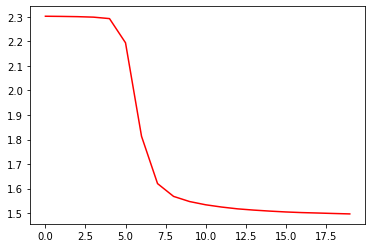

In [16]:
net = train(Net(nf=1, nclass=10, model_type="MNIST", activate_fn=ACTIVATE_FN["LEAKYRELU"]), trainloader_mnist, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 157/157 [00:01<00:00, 86.28it/s]



Accuracy of     0 : 99 %
Accuracy of     1 : 98 %
Accuracy of     2 : 98 %
Accuracy of     3 : 98 %
Accuracy of     4 : 96 %
Accuracy of     5 : 96 %
Accuracy of     6 : 98 %
Accuracy of     7 : 94 %
Accuracy of     8 : 93 %
Accuracy of     9 : 95 %
Accuracy of   ALL : 96 %


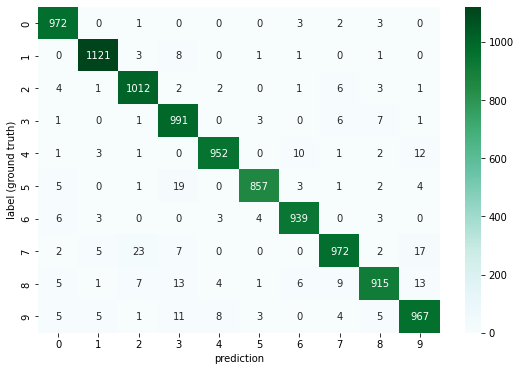

In [17]:
test(net, testloader_mnist, numlabel=NUM_LABEL["MNIST"])

##TEST CASE : KMNIST / RELU / 20 EPS 

epoch: 0


100%|██████████| 938/938 [00:11<00:00, 79.63it/s]



 epoch_loss: 2.302
epoch: 1


100%|██████████| 938/938 [00:11<00:00, 80.64it/s]



 epoch_loss: 2.302
epoch: 2


100%|██████████| 938/938 [00:11<00:00, 80.01it/s]



 epoch_loss: 2.301
epoch: 3


100%|██████████| 938/938 [00:12<00:00, 74.01it/s]



 epoch_loss: 2.299
epoch: 4


100%|██████████| 938/938 [00:11<00:00, 80.61it/s]



 epoch_loss: 2.287
epoch: 5


100%|██████████| 938/938 [00:11<00:00, 80.80it/s]



 epoch_loss: 2.098
epoch: 6


100%|██████████| 938/938 [00:11<00:00, 81.29it/s]



 epoch_loss: 1.847
epoch: 7


100%|██████████| 938/938 [00:11<00:00, 79.74it/s]



 epoch_loss: 1.800
epoch: 8


100%|██████████| 938/938 [00:11<00:00, 82.26it/s]



 epoch_loss: 1.783
epoch: 9


100%|██████████| 938/938 [00:11<00:00, 81.62it/s]



 epoch_loss: 1.771
epoch: 10


100%|██████████| 938/938 [00:11<00:00, 79.61it/s]



 epoch_loss: 1.760
epoch: 11


100%|██████████| 938/938 [00:11<00:00, 79.38it/s]



 epoch_loss: 1.751
epoch: 12


100%|██████████| 938/938 [00:11<00:00, 78.98it/s]



 epoch_loss: 1.732
epoch: 13


100%|██████████| 938/938 [00:11<00:00, 79.13it/s]



 epoch_loss: 1.687
epoch: 14


100%|██████████| 938/938 [00:11<00:00, 81.81it/s]



 epoch_loss: 1.662
epoch: 15


100%|██████████| 938/938 [00:11<00:00, 79.49it/s]



 epoch_loss: 1.645
epoch: 16


100%|██████████| 938/938 [00:11<00:00, 79.58it/s]



 epoch_loss: 1.634
epoch: 17


100%|██████████| 938/938 [00:11<00:00, 80.87it/s]



 epoch_loss: 1.624
epoch: 18


100%|██████████| 938/938 [00:11<00:00, 79.34it/s]



 epoch_loss: 1.618
epoch: 19


100%|██████████| 938/938 [00:13<00:00, 69.14it/s]



 epoch_loss: 1.612
Finished Training for 236.83 s
show loss


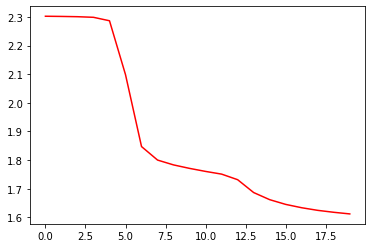

In [55]:
net = train(Net(nf=1, nclass=10, model_type="KMNIST"), trainloader_kmnist, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 157/157 [00:01<00:00, 82.48it/s]



Accuracy of     0 : 81 %
Accuracy of     1 : 72 %
Accuracy of     2 : 65 %
Accuracy of     3 : 92 %
Accuracy of     4 : 72 %
Accuracy of     5 : 26 %
Accuracy of     6 : 79 %
Accuracy of     7 : 47 %
Accuracy of     8 : 76 %
Accuracy of     9 : 81 %
Accuracy of   ALL : 69 %


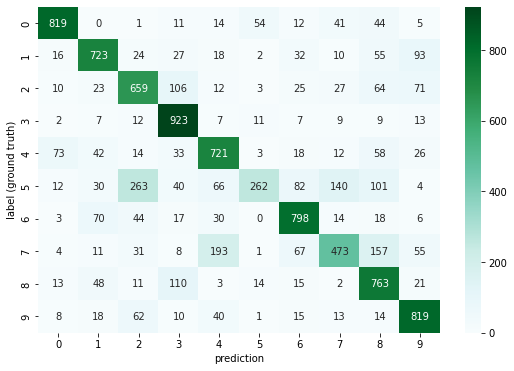

In [56]:
test(net, testloader_kmnist, numlabel=NUM_LABEL["KMNIST"])

##TEST CASE : KMNIST / ELU / 20 EPS


epoch: 0


100%|██████████| 938/938 [00:11<00:00, 80.89it/s]



 epoch_loss: 2.301
epoch: 1


100%|██████████| 938/938 [00:11<00:00, 79.91it/s]



 epoch_loss: 2.289
epoch: 2


100%|██████████| 938/938 [00:11<00:00, 81.06it/s]



 epoch_loss: 2.169
epoch: 3


100%|██████████| 938/938 [00:11<00:00, 81.12it/s]



 epoch_loss: 1.956
epoch: 4


100%|██████████| 938/938 [00:11<00:00, 80.44it/s]



 epoch_loss: 1.843
epoch: 5


100%|██████████| 938/938 [00:12<00:00, 76.71it/s]



 epoch_loss: 1.795
epoch: 6


100%|██████████| 938/938 [00:11<00:00, 81.59it/s]



 epoch_loss: 1.762
epoch: 7


100%|██████████| 938/938 [00:11<00:00, 81.11it/s]



 epoch_loss: 1.736
epoch: 8


100%|██████████| 938/938 [00:12<00:00, 76.09it/s]



 epoch_loss: 1.718
epoch: 9


100%|██████████| 938/938 [00:11<00:00, 81.66it/s]



 epoch_loss: 1.685
epoch: 10


100%|██████████| 938/938 [00:11<00:00, 82.38it/s]



 epoch_loss: 1.667
epoch: 11


100%|██████████| 938/938 [00:11<00:00, 81.81it/s]



 epoch_loss: 1.657
epoch: 12


100%|██████████| 938/938 [00:11<00:00, 82.24it/s]



 epoch_loss: 1.647
epoch: 13


100%|██████████| 938/938 [00:11<00:00, 81.64it/s]



 epoch_loss: 1.641
epoch: 14


100%|██████████| 938/938 [00:11<00:00, 80.69it/s]



 epoch_loss: 1.634
epoch: 15


100%|██████████| 938/938 [00:11<00:00, 81.91it/s]



 epoch_loss: 1.629
epoch: 16


100%|██████████| 938/938 [00:11<00:00, 82.83it/s]



 epoch_loss: 1.624
epoch: 17


100%|██████████| 938/938 [00:11<00:00, 82.77it/s]



 epoch_loss: 1.620
epoch: 18


100%|██████████| 938/938 [00:11<00:00, 82.14it/s]



 epoch_loss: 1.617
epoch: 19


100%|██████████| 938/938 [00:11<00:00, 80.80it/s]



 epoch_loss: 1.611
Finished Training for 231.95 s
show loss


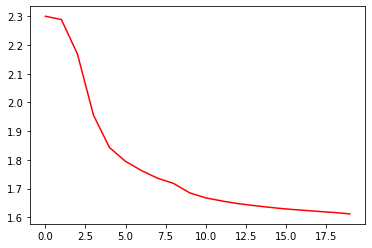

In [20]:
net = train(Net(nf=1, nclass=10, model_type="KMNIST", activate_fn=ACTIVATE_FN["ELU"]), trainloader_kmnist, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 157/157 [00:01<00:00, 84.06it/s]



Accuracy of     0 : 86 %
Accuracy of     1 : 68 %
Accuracy of     2 : 53 %
Accuracy of     3 : 94 %
Accuracy of     4 : 75 %
Accuracy of     5 : 26 %
Accuracy of     6 : 88 %
Accuracy of     7 : 47 %
Accuracy of     8 : 82 %
Accuracy of     9 : 81 %
Accuracy of   ALL : 70 %


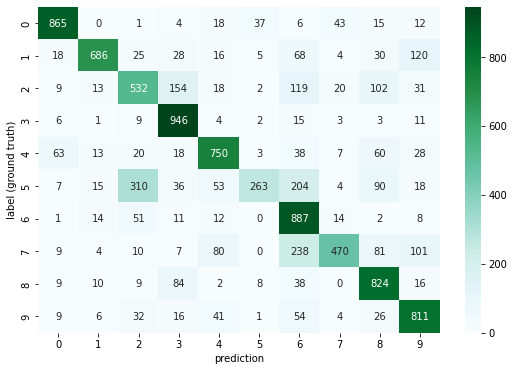

In [21]:
test(net, testloader_kmnist, numlabel=NUM_LABEL["KMNIST"])

##TEST CASE : KMNIST / LEAKYRELU / 20 EPS 

epoch: 0


100%|██████████| 938/938 [00:11<00:00, 80.51it/s]



 epoch_loss: 2.303
epoch: 1


100%|██████████| 938/938 [00:11<00:00, 82.49it/s]



 epoch_loss: 2.302
epoch: 2


100%|██████████| 938/938 [00:11<00:00, 81.98it/s]



 epoch_loss: 2.301
epoch: 3


100%|██████████| 938/938 [00:11<00:00, 81.39it/s]



 epoch_loss: 2.298
epoch: 4


100%|██████████| 938/938 [00:11<00:00, 82.13it/s]



 epoch_loss: 2.284
epoch: 5


100%|██████████| 938/938 [00:11<00:00, 82.29it/s]



 epoch_loss: 2.177
epoch: 6


100%|██████████| 938/938 [00:11<00:00, 81.42it/s]



 epoch_loss: 1.976
epoch: 7


100%|██████████| 938/938 [00:11<00:00, 81.66it/s]



 epoch_loss: 1.861
epoch: 8


100%|██████████| 938/938 [00:11<00:00, 82.82it/s]



 epoch_loss: 1.815
epoch: 9


100%|██████████| 938/938 [00:11<00:00, 81.55it/s]



 epoch_loss: 1.794
epoch: 10


100%|██████████| 938/938 [00:11<00:00, 83.35it/s]



 epoch_loss: 1.778
epoch: 11


100%|██████████| 938/938 [00:11<00:00, 82.46it/s]



 epoch_loss: 1.767
epoch: 12


100%|██████████| 938/938 [00:11<00:00, 81.60it/s]



 epoch_loss: 1.759
epoch: 13


100%|██████████| 938/938 [00:11<00:00, 81.36it/s]



 epoch_loss: 1.751
epoch: 14


100%|██████████| 938/938 [00:11<00:00, 81.69it/s]



 epoch_loss: 1.745
epoch: 15


100%|██████████| 938/938 [00:11<00:00, 82.54it/s]



 epoch_loss: 1.718
epoch: 16


100%|██████████| 938/938 [00:11<00:00, 83.02it/s]



 epoch_loss: 1.704
epoch: 17


100%|██████████| 938/938 [00:11<00:00, 82.51it/s]



 epoch_loss: 1.696
epoch: 18


100%|██████████| 938/938 [00:11<00:00, 82.51it/s]



 epoch_loss: 1.681
epoch: 19


100%|██████████| 938/938 [00:11<00:00, 83.17it/s]



 epoch_loss: 1.652
Finished Training for 228.66 s
show loss


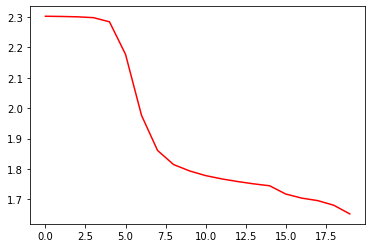

In [63]:
net = train(Net(nf=1, nclass=10, model_type="KMNIST", activate_fn=ACTIVATE_FN["LEAKYRELU"]), trainloader_kmnist, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 157/157 [00:01<00:00, 81.94it/s]



Accuracy of     0 : 79 %
Accuracy of     1 : 67 %
Accuracy of     2 : 47 %
Accuracy of     3 : 87 %
Accuracy of     4 : 76 %
Accuracy of     5 : 26 %
Accuracy of     6 : 79 %
Accuracy of     7 : 50 %
Accuracy of     8 : 82 %
Accuracy of     9 : 81 %
Accuracy of   ALL : 67 %


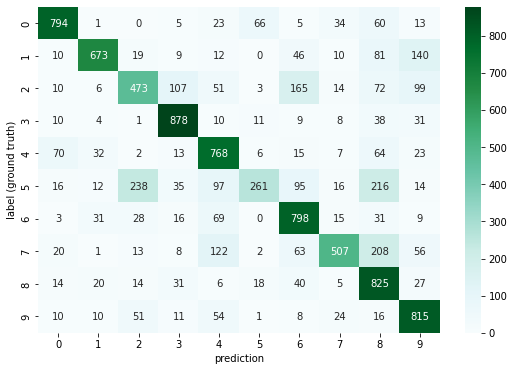

In [64]:
test(net, testloader_kmnist, numlabel=NUM_LABEL["KMNIST"])

##CHANGE EPOCHS 20 -> 30 EPS

In [29]:
EPOCHS = 30

##TEST CASE FLOWER / RELU / 30 EPS

epoch: 0


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]



 epoch_loss: 4.496
epoch: 1


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 4.083
epoch: 2


100%|██████████| 97/97 [00:45<00:00,  2.12it/s]



 epoch_loss: 3.716
epoch: 3


100%|██████████| 97/97 [00:46<00:00,  2.09it/s]



 epoch_loss: 3.400
epoch: 4


100%|██████████| 97/97 [00:46<00:00,  2.10it/s]



 epoch_loss: 3.098
epoch: 5


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 2.878
epoch: 6


100%|██████████| 97/97 [00:43<00:00,  2.21it/s]



 epoch_loss: 2.608
epoch: 7


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]



 epoch_loss: 2.425
epoch: 8


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 2.194
epoch: 9


100%|██████████| 97/97 [00:43<00:00,  2.22it/s]



 epoch_loss: 2.027
epoch: 10


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 1.872
epoch: 11


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 1.697
epoch: 12


100%|██████████| 97/97 [00:45<00:00,  2.12it/s]



 epoch_loss: 1.547
epoch: 13


100%|██████████| 97/97 [00:43<00:00,  2.22it/s]



 epoch_loss: 1.390
epoch: 14


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 1.197
epoch: 15


100%|██████████| 97/97 [00:43<00:00,  2.22it/s]



 epoch_loss: 1.050
epoch: 16


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 0.951
epoch: 17


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]



 epoch_loss: 0.735
epoch: 18


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 0.637
epoch: 19


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.462
epoch: 20


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.338
epoch: 21


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]



 epoch_loss: 0.318
epoch: 22


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.253
epoch: 23


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.282
epoch: 24


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.196
epoch: 25


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 0.125
epoch: 26


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 0.071
epoch: 27


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]



 epoch_loss: 0.054
epoch: 28


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.051
epoch: 29


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.057
Finished Training for 1340.18 s
show loss


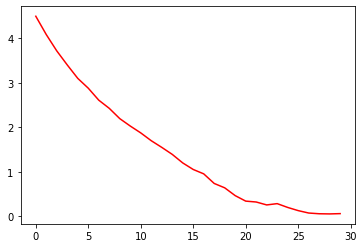

In [30]:
net = train(Net(nf=3, nclass=102, model_type="FLOWER"), trainloader_flower, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 16/16 [00:07<00:00,  2.22it/s]



Accuracy of     0 : 30 %
Accuracy of     1 : 100 %
Accuracy of     2 :  0 %
Accuracy of     3 : 20 %
Accuracy of     4 : 30 %
Accuracy of     5 : 40 %
Accuracy of     6 : 40 %
Accuracy of     7 : 80 %
Accuracy of     8 : 20 %
Accuracy of     9 : 40 %
Accuracy of    10 : 10 %
Accuracy of    11 : 80 %
Accuracy of    12 : 40 %
Accuracy of    13 : 70 %
Accuracy of    14 : 20 %
Accuracy of    15 :  0 %
Accuracy of    16 : 80 %
Accuracy of    17 : 20 %
Accuracy of    18 : 20 %
Accuracy of    19 : 30 %
Accuracy of    20 : 60 %
Accuracy of    21 : 30 %
Accuracy of    22 : 80 %
Accuracy of    23 : 40 %
Accuracy of    24 : 20 %
Accuracy of    25 : 30 %
Accuracy of    26 : 20 %
Accuracy of    27 : 40 %
Accuracy of    28 : 50 %
Accuracy of    29 : 50 %
Accuracy of    30 : 30 %
Accuracy of    31 : 10 %
Accuracy of    32 : 10 %
Accuracy of    33 : 20 %
Accuracy of    34 : 60 %
Accuracy of    35 : 50 %
Accuracy of    36 : 80 %
Accuracy of    37 : 20 %
Accuracy of    38 : 10 %
Accuracy of    39 : 20 

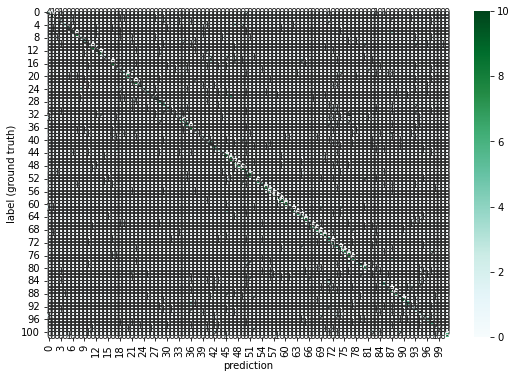

In [31]:
test(net, testloader_flower, numlabel=NUM_LABEL["FLOWER"])

##TEST CASE FLOWER / ELU / 30 EPS

epoch: 0


100%|██████████| 97/97 [00:45<00:00,  2.14it/s]



 epoch_loss: 4.313
epoch: 1


100%|██████████| 97/97 [00:45<00:00,  2.11it/s]



 epoch_loss: 3.764
epoch: 2


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 3.414
epoch: 3


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 3.138
epoch: 4


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 2.900
epoch: 5


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]



 epoch_loss: 2.663
epoch: 6


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]



 epoch_loss: 2.442
epoch: 7


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 2.276
epoch: 8


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 2.082
epoch: 9


100%|██████████| 97/97 [00:47<00:00,  2.02it/s]



 epoch_loss: 1.919
epoch: 10


100%|██████████| 97/97 [00:47<00:00,  2.06it/s]



 epoch_loss: 1.748
epoch: 11


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]



 epoch_loss: 1.582
epoch: 12


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 1.471
epoch: 13


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 1.302
epoch: 14


100%|██████████| 97/97 [00:45<00:00,  2.14it/s]



 epoch_loss: 1.141
epoch: 15


100%|██████████| 97/97 [00:45<00:00,  2.13it/s]



 epoch_loss: 1.030
epoch: 16


100%|██████████| 97/97 [00:46<00:00,  2.09it/s]



 epoch_loss: 0.892
epoch: 17


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.746
epoch: 18


100%|██████████| 97/97 [00:46<00:00,  2.07it/s]



 epoch_loss: 0.642
epoch: 19


100%|██████████| 97/97 [00:45<00:00,  2.12it/s]



 epoch_loss: 0.502
epoch: 20


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]



 epoch_loss: 0.402
epoch: 21


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.459
epoch: 22


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.285
epoch: 23


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.224
epoch: 24


100%|██████████| 97/97 [00:46<00:00,  2.10it/s]



 epoch_loss: 0.177
epoch: 25


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.154
epoch: 26


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.107
epoch: 27


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.083
epoch: 28


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.071
epoch: 29


100%|██████████| 97/97 [00:46<00:00,  2.08it/s]



 epoch_loss: 0.058
Finished Training for 1356.68 s
show loss


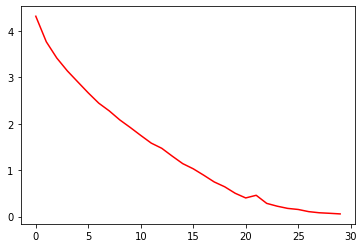

In [32]:
net = train(Net(nf=3, nclass=102, model_type="FLOWER", activate_fn=ACTIVATE_FN["ELU"]), trainloader_flower, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 16/16 [00:07<00:00,  2.20it/s]



Accuracy of     0 : 40 %
Accuracy of     1 : 100 %
Accuracy of     2 : 10 %
Accuracy of     3 : 20 %
Accuracy of     4 : 50 %
Accuracy of     5 : 40 %
Accuracy of     6 : 50 %
Accuracy of     7 : 90 %
Accuracy of     8 : 30 %
Accuracy of     9 : 50 %
Accuracy of    10 :  0 %
Accuracy of    11 : 60 %
Accuracy of    12 : 40 %
Accuracy of    13 : 70 %
Accuracy of    14 : 40 %
Accuracy of    15 : 20 %
Accuracy of    16 : 90 %
Accuracy of    17 : 30 %
Accuracy of    18 : 20 %
Accuracy of    19 : 20 %
Accuracy of    20 : 40 %
Accuracy of    21 : 40 %
Accuracy of    22 : 50 %
Accuracy of    23 : 40 %
Accuracy of    24 : 30 %
Accuracy of    25 : 50 %
Accuracy of    26 : 30 %
Accuracy of    27 : 60 %
Accuracy of    28 : 70 %
Accuracy of    29 : 50 %
Accuracy of    30 : 20 %
Accuracy of    31 : 20 %
Accuracy of    32 : 20 %
Accuracy of    33 : 40 %
Accuracy of    34 : 50 %
Accuracy of    35 : 30 %
Accuracy of    36 : 90 %
Accuracy of    37 : 40 %
Accuracy of    38 :  0 %
Accuracy of    39 : 20 

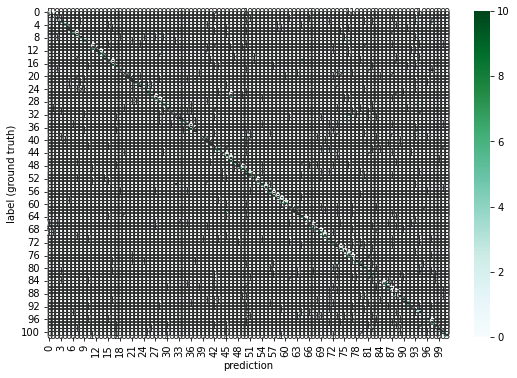

In [33]:
test(net, testloader_flower, numlabel=NUM_LABEL["FLOWER"])

##TEST CASE FLOWER / RELU / 30 EPS

epoch: 0


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 4.484
epoch: 1


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 4.077
epoch: 2


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 3.689
epoch: 3


100%|██████████| 97/97 [00:46<00:00,  2.07it/s]



 epoch_loss: 3.367
epoch: 4


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 3.085
epoch: 5


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 2.828
epoch: 6


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 2.604
epoch: 7


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 2.408
epoch: 8


100%|██████████| 97/97 [00:46<00:00,  2.09it/s]



 epoch_loss: 2.194
epoch: 9


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 1.979
epoch: 10


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 1.824
epoch: 11


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 1.633
epoch: 12


100%|██████████| 97/97 [00:45<00:00,  2.15it/s]



 epoch_loss: 1.439
epoch: 13


100%|██████████| 97/97 [00:46<00:00,  2.08it/s]



 epoch_loss: 1.246
epoch: 14


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 1.108
epoch: 15


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.939
epoch: 16


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 0.758
epoch: 17


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.654
epoch: 18


100%|██████████| 97/97 [00:46<00:00,  2.10it/s]



 epoch_loss: 0.656
epoch: 19


100%|██████████| 97/97 [00:44<00:00,  2.18it/s]



 epoch_loss: 0.363
epoch: 20


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.275
epoch: 21


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 0.284
epoch: 22


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.151
epoch: 23


100%|██████████| 97/97 [00:46<00:00,  2.07it/s]



 epoch_loss: 0.151
epoch: 24


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 0.088
epoch: 25


100%|██████████| 97/97 [00:44<00:00,  2.17it/s]



 epoch_loss: 0.076
epoch: 26


100%|██████████| 97/97 [00:44<00:00,  2.19it/s]



 epoch_loss: 0.263
epoch: 27


100%|██████████| 97/97 [00:44<00:00,  2.16it/s]



 epoch_loss: 0.094
epoch: 28


100%|██████████| 97/97 [00:47<00:00,  2.06it/s]



 epoch_loss: 0.050
epoch: 29


100%|██████████| 97/97 [00:44<00:00,  2.20it/s]



 epoch_loss: 0.037
Finished Training for 1349.54 s
show loss


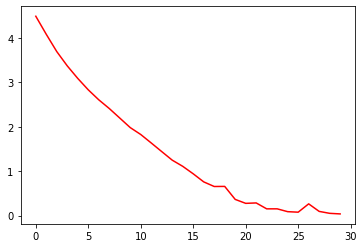

In [34]:
net = train(Net(nf=3, nclass=102, model_type="FLOWER", activate_fn=ACTIVATE_FN["LEAKYRELU"]), trainloader_flower, epochs=EPOCHS, lr=LEARNING_RATE)

start testing...


100%|██████████| 16/16 [00:07<00:00,  2.18it/s]



Accuracy of     0 : 30 %
Accuracy of     1 : 100 %
Accuracy of     2 :  0 %
Accuracy of     3 : 10 %
Accuracy of     4 : 20 %
Accuracy of     5 : 60 %
Accuracy of     6 : 60 %
Accuracy of     7 : 70 %
Accuracy of     8 : 20 %
Accuracy of     9 : 80 %
Accuracy of    10 : 10 %
Accuracy of    11 : 100 %
Accuracy of    12 : 30 %
Accuracy of    13 : 80 %
Accuracy of    14 : 60 %
Accuracy of    15 : 30 %
Accuracy of    16 : 70 %
Accuracy of    17 : 10 %
Accuracy of    18 : 10 %
Accuracy of    19 : 20 %
Accuracy of    20 : 30 %
Accuracy of    21 : 70 %
Accuracy of    22 : 50 %
Accuracy of    23 : 30 %
Accuracy of    24 : 40 %
Accuracy of    25 : 10 %
Accuracy of    26 : 20 %
Accuracy of    27 : 50 %
Accuracy of    28 : 100 %
Accuracy of    29 : 60 %
Accuracy of    30 : 10 %
Accuracy of    31 : 20 %
Accuracy of    32 :  0 %
Accuracy of    33 : 30 %
Accuracy of    34 : 50 %
Accuracy of    35 : 40 %
Accuracy of    36 : 80 %
Accuracy of    37 : 30 %
Accuracy of    38 :  0 %
Accuracy of    39 : 4

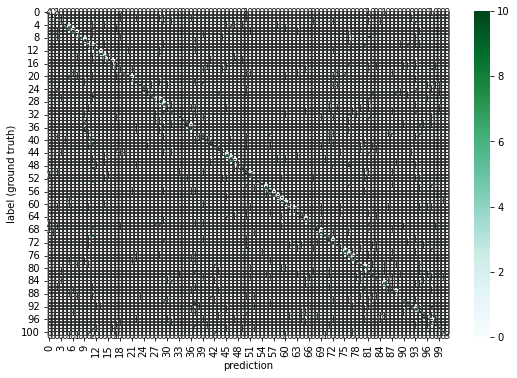

In [35]:
test(net, testloader_flower, numlabel=NUM_LABEL["FLOWER"])